In [135]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import numpy as np
import math
 

df = pd.read_csv("C:/Users/yvonna/OneDrive/桌面/digitalent/DIGI_TCA_2021/data/skuName_D2_v3.csv")
df["DATE"] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
dateperiod = pd.date_range("2019/1/2","2021/9/1",freq="D")
dateperiod = pd.DataFrame(dateperiod)
dateperiod.rename(columns={0:'DATE'},inplace = True)
df = dateperiod.merge(df, how = "left")
df['ConsumedQuantity'] = df["ConsumedQuantity"].fillna(0)
df.rename(columns={'DATE':'ds','ConsumedQuantity':'y'},inplace = True)
df = df[:-1]

df = pd.read_csv('skuName_D2_v3.csv', index_col='DATE', parse_dates=['DATE'])[:-1]
df = df.asfreq('d').fillna(0)
df

class Prophet_model:

    def __init__(self, train_test_split):
        self.split_ratio = train_test_split
        self.data = None
        self.model = None
        self.forecast = None

    def fit(self, data):
        self.data = data
        train = self.data[:int(self.split_ratio*(len(self.data)))]

        model = Prophet()
        model.fit(train)
        self.model = model

    def evaluation(self):
        future = self.model.make_future_dataframe(len(self.data[int(self.split_ratio*(len(self.data)))-1:]))
        self.forecast = self.model.predict(future)
        start_index = int(self.split_ratio*(len(self.data)))
        y_pred = self.forecast[['ds', 'yhat']].iloc[start_index:,]
        y_true = self.data.iloc[start_index:]
        combine = pd.merge(y_pred, y_true, on='ds', how='left').dropna()
        rmse = (((combine['yhat']-combine['y'])**2).mean())**(1/2)
        print('\n')
        print('RMSE:', rmse)
        

    def plot(self):
        self.model.plot(self.forecast)
        start_index = int(self.split_ratio*(len(self.data)))
        plt.scatter(self.data.iloc[start_index:,0], self.data.iloc[start_index:,1], color='r', s=10)
        plt.show()
        

prohet_model = Prophet_model(0.9)
prohet_model.fit(df)
prohet_model.evaluation()
prohet_model.plot()

In [143]:
class Prophet_model:

    def __init__(self, predict_step):
        self.predict_step = predict_step
        self.data = None
        self.model = None
        self.forecast = None

    def fit(self, data, seasonality_model='multiplicative'):
        self.data = data
        train = self.data[:-self.predict_step]

        model = Prophet(seasonality_mode = seasonality_model, changepoint_prior_scale=0.9)
        model.add_seasonality(name='weekly', period=7, fourier_order=3)
        model.fit(train)
        self.model = model

    def evaluation(self):
        future = self.model.make_future_dataframe(self.predict_step)
        forecast = self.model.predict(future)
        self.forecast = forecast[['ds', 'yhat']].iloc[-self.predict_step:,]
        observed = self.data.iloc[-self.predict_step:]
        rmse = (((self.forecast['yhat']-observed['y'])**2).mean())**(1/2)
        print('\n')
        print('RMSE:', rmse)
        
    def plot(self, start):
        data = self.data.set_index('ds')
        forecast = self.forecast.set_index('ds')
        
        plt.figure(figsize=(12,6))
        plt.plot(data[start:], label='Observed')
        plt.plot(forecast, label='Forecasting')
        plt.xticks(rotation=45)
        plt.title('Consumed Quantity of SkuName D2_v3\n Prophet, {}-step Forecasting'.format(self.predict_step), size=15)
        plt.xlabel('Date')
        plt.ylabel('Consumed Quantity')
        plt.legend()
        plt.show()
        
        self.forecast_plot = forecast
        self.observed_plot = self.data[-self.predict_step-1:]
        self.past_plot = self.data[:-self.predict_step:]
    
    def recommendation(self):
        price_for_recom = pd.concat([self.past_plot[-23:].rename(columns={'y':'ConsumedQuantity'}), pd.DataFrame(prohet_model.forecast_plot[1:].rename(columns={'yhat':'ConsumedQuantity'}))])
        price_for_recom.set_index('ds',inplace = True)
        max_amount = math.ceil(max(price_for_recom['ConsumedQuantity'])/24)
        min_amount = math.floor(min(price_for_recom['ConsumedQuantity'])/24)

        RI_1list = []
        RI_3list = []
        EA_price = 0.13
        RI_1price = 52.92
        RI_3price = 33.61
        print('EA Price:', (price_for_recom*EA_price).sum().values[0])
        for i in range(min_amount, max_amount+1):
            EA = price_for_recom-24*i
            EA.loc[EA['ConsumedQuantity']<0, 'ConsumedQuantity'] = 0
            EA_total = (EA*EA_price).sum().values[0]
            print(i, 'RI (1 year)', RI_1price*i+EA_total)
            RI_1list.append(RI_1price*i+EA_total)
            print(i, 'RI (3 year)', RI_3price*i+EA_total)
            RI_3list.append(RI_3price*i+EA_total)
            print('\n')
        recommendation = pd.DataFrame(list(zip(range(min_amount, max_amount+1), RI_1list, RI_3list)), columns =['Amount', 'RI (1 year)', 'RI (3 year)'])
        recommendation['EA Price'] = (price_for_recom*EA_price).sum().values[0]
        self.recommendation = recommendation
        print('For RI (1 year), we recommend you buy {} RI with ${}'.format(range(min_amount, max_amount+1)[np.argmin(RI_1list)], min(np.round(RI_1list,2))))
        print('For RI (3 year), we recommend you buy {} RI with ${}'.format(range(min_amount, max_amount+1)[np.argmin(RI_3list)], min(np.round(RI_3list,2))))


INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.




RMSE: 2.697162905609018


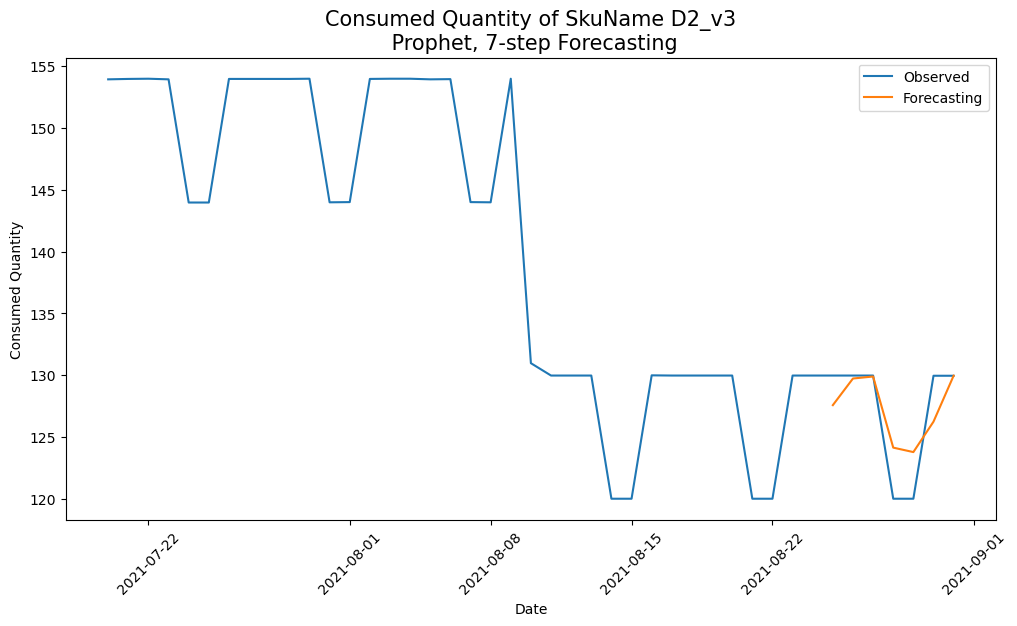

EA Price: 505.19949475773257
5 RI (1 year) 317.3994947577326
5 RI (3 year) 220.8494947577326


6 RI (1 year) 325.29402288
6 RI (3 year) 209.43402288


7 RI (1 year) 370.44
7 RI (3 year) 235.26999999999998


For RI (1 year), we recommend you buy 5 RI with $317.4
For RI (3 year), we recommend you buy 6 RI with $209.43


In [147]:
prohet_model = Prophet_model(predict_step=7)
prohet_model.fit(df, seasonality_model='multiplicative')
prohet_model.evaluation()
prohet_model.plot('2021-07-20')
prohet_model.recommendation()

A = pd.concat([df.iloc[[965,],[0,1]].rename(columns={'y':'yhat'}), prohet_model.forecast])
A.rename(columns={'ds':'DATE','yhat':'ConsumedQuantity'},inplace = True)
A.to_csv("A.csv", index=False)

prohet_model.recommendation.to_csv("prohet_model.recommendation.csv", index=False)

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.




RMSE: 4.165385683021283


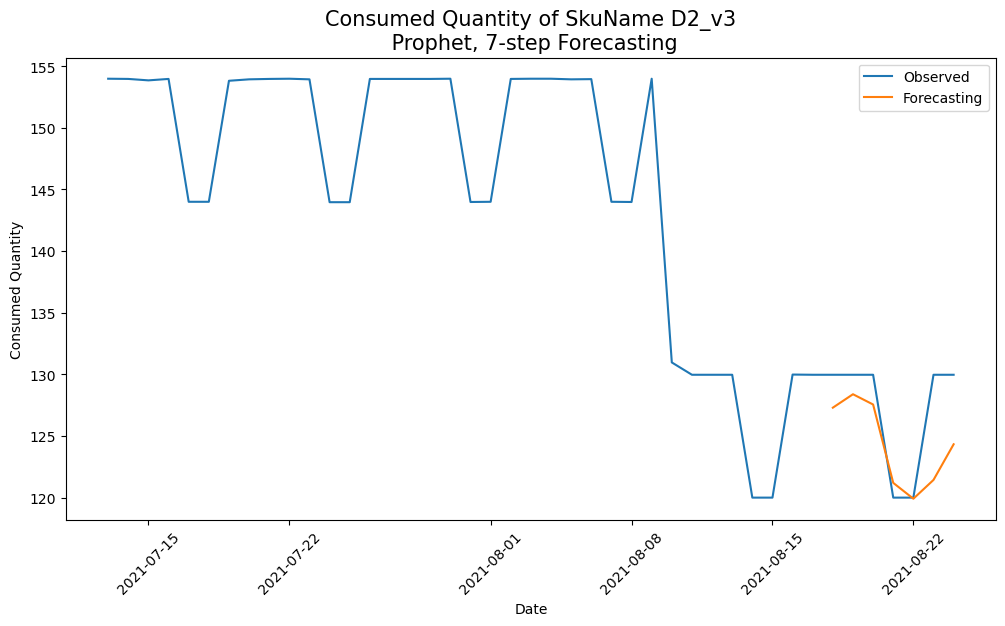

In [96]:
prohet_model = Prophet_model(predict_step=7)
prohet_model.fit(df[:-7], seasonality_model='multiplicative')
prohet_model.evaluation()
prohet_model.plot('2021-07-13')
B = pd.concat([df.iloc[[958,],[0,1]].rename(columns={'y':'yhat'}), prohet_model.forecast])
B.rename(columns={'ds':'DATE','yhat':'ConsumedQuantity'},inplace = True)
B.to_csv("B.csv", index=False)

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.




RMSE: 5.264230120059009


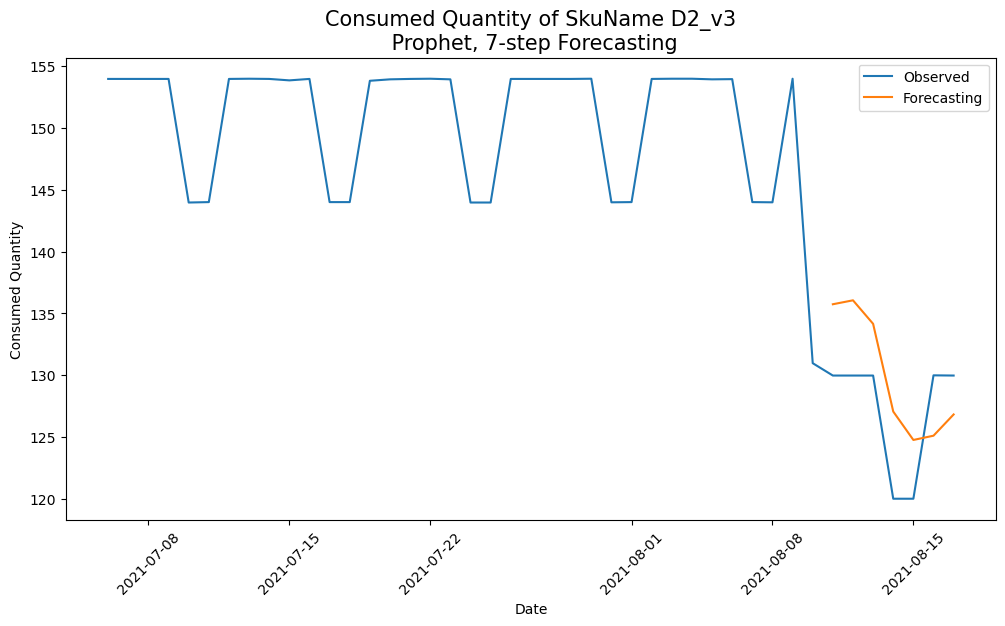

In [72]:
prohet_model = Prophet_model(predict_step=7)
prohet_model.fit(df[:-14], seasonality_model='multiplicative')
prohet_model.evaluation()
prohet_model.plot('2021-07-06')
C = pd.concat([df.iloc[[951,],[0,1]].rename(columns={'y':'yhat'}), prohet_model.forecast])
C.rename(columns={'ds':'DATE','yhat':'ConsumedQuantity'},inplace = True)
C.to_csv("C.csv", index=False) 

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.




RMSE: 12.719781555113052


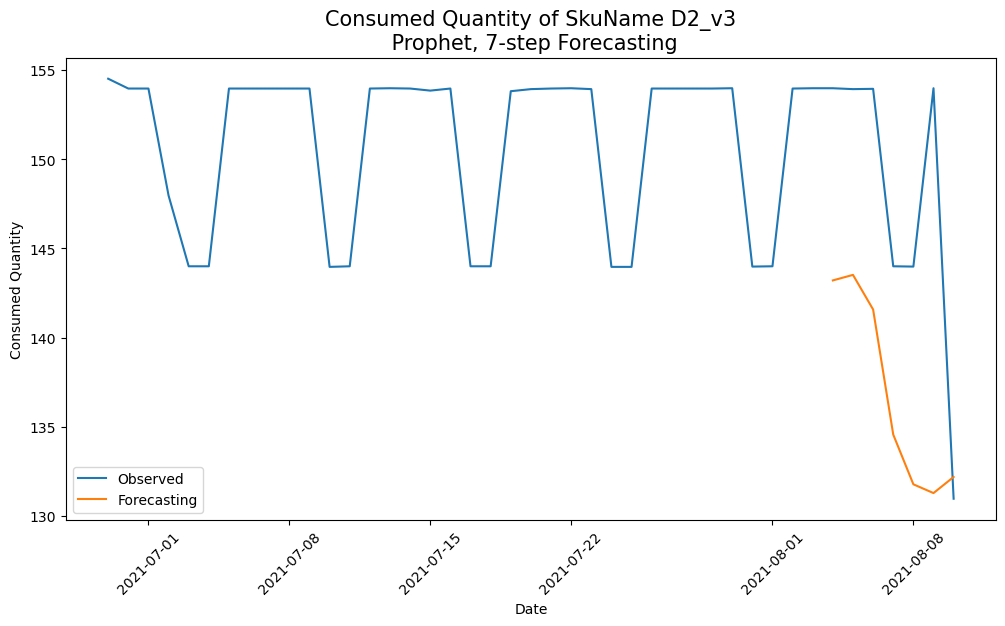

In [59]:
prohet_model = Prophet_model(predict_step=7)
prohet_model.fit(df[:-21], seasonality_model='multiplicative')
prohet_model.evaluation()
prohet_model.plot('2021-06-29')
D = pd.concat([df.iloc[[944,],[0,1]].rename(columns={'y':'yhat'}), prohet_model.forecast])
D.rename(columns={'ds':'DATE','yhat':'ConsumedQuantity'},inplace = True)
D.to_csv("D.csv", index=False) 

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.




RMSE: 4.757955493872167


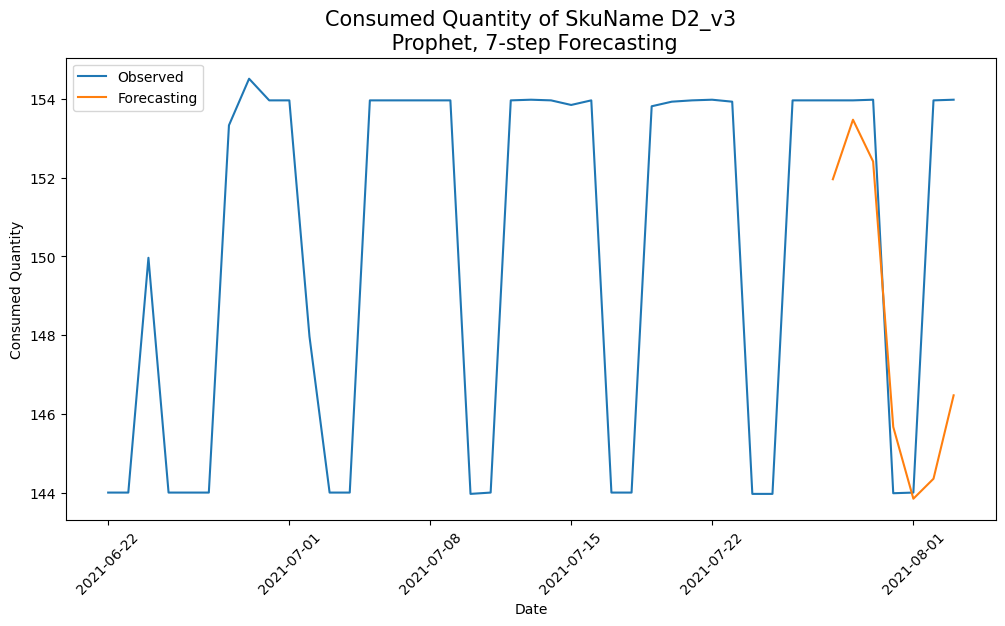

In [58]:
prohet_model = Prophet_model(predict_step=7)
prohet_model.fit(df[:-28], seasonality_model='multiplicative')
prohet_model.evaluation()
prohet_model.plot('2021-06-22')
E = pd.concat([df.iloc[[937,],[0,1]].rename(columns={'y':'yhat'}), prohet_model.forecast])
E.rename(columns={'ds':'DATE','yhat':'ConsumedQuantity'},inplace = True)
E.to_csv("E.csv", index=False) 